# ***PROYECTO ESPECIALIZACIÓN EN CIENCIA DE DATOS E IA***

**Presentado por:** 
- Jonatan Andres Londoño Taborda
- John Freddy Ossa Patiño
- Felipe Londoño Mendoza

--------------------------------------------

# 📘 Contexto del Proyecto

El presente trabajo tiene como objetivo construir un modelo supervisado de clasificación que permita automatizar la decisión sobre el tratamiento de órdenes de desviaciones significativas en consumos de los servicios de energía, acueducto, alcantarillado y gas que presta Empresas Públicas de Medellín (EPM) a sus clientes, generadas cuando se detectan consumos que se salen de unos rangos establecidos por ley en un periodo determinado.

Actualmente, estas órdenes son revisadas manualmente por un equipo de analistas que determina si deben legalizar o enviarse una revisión a terreno para tener mas argumentos. El desarrollo de este modelo busca replicar ese proceso humano a partir de datos históricos, con el fin de reducir visitas innecesarias y optimizar los costos operativos asociados.

---

## 🧪 Proceso de Análisis

Para lograr este objetivo, se ejecutará el siguiente flujo de trabajo:

1. **Análisis Exploratorio de Datos (EDA)**
2. **Depuración y preparación de los datos**
3. **Entrenamiento y comparación de modelos de clasificación**:
   - Regresión Logística
   - Random Forest
   - XGBoost Lineal
4. **Conclusiones**

---

## 📊 Evaluación y Métricas

- Se evaluará el desempeño de cada modelo utilizando la métrica F1 Score, ideal para escenarios con datos desbalanceados, ya que equilibra la precisión.
- La división de los datos será del 80% para entrenamiento y 20% para prueba.

Además, el modelo generará una probabilidad de legalización para cada orden. Si esta probabilidad supera el 80%, se considerará que la orden puede ser legalizada automáticamente, sin la intervención de un analista.

---


## 📂 Descripción de los Datos

Para el entrenamiento del modelo supervisado de clasificación se cuenta con un conjunto de datos históricos que contiene información sobre órdenes de desviación significativa generadas por incrementos en el consumo de servicios públicos. Estas órdenes fueron previamente revisadas por analistas, quienes tomaron decisiones basadas en las condiciones observadas.

### 🎯 Variable Objetivo: `RESPUESTA`

La variable `RESPUESTA` representa la decisión final tomada por el analista, y se comporta de la siguiente manera:

| Caso | ¿Modifica Consumo? | ¿Envía a terreno? | RESPUESTA |
|------|--------------------|-------------------|-----------|
| 1    | Sí                 | No                | 1         |
| 2    | Sí                 | Sí                | 1         |
| 3    | No                 | Sí                | 1         |
| 4    | No                 | No                | 0         |

#### 🧠 Interpretación de los casos:
- **Caso 1:** El analista detecta un error claro en el consumo y lo ajusta sin necesidad de verificación en terreno.
- **Caso 2:** El analista ajusta parcialmente el consumo, pero requiere una visita en terreno para validar la parte restante antes de decidir su facturación definitiva.
- **Caso 3:** El analista no ajusta el consumo por falta de evidencia suficiente, pero mantiene dudas que requieren una inspección en terreno.
- **Caso 4:** El consumo investigado es considerado válido y no necesita ajustes ni verificación en terreno.

Por tanto, la clase `1` agrupa todas las situaciones en las que se toma alguna acción correctiva o preventiva adicional, mientras que la clase `0` representa los casos cerrados sin intervención alguna.

---

### 🧾 Variables Predictoras

Las demás columnas del dataset representan condiciones observadas por el analista en el momento de tomar la decisión, y serán utilizadas como **variables predictoras** en el modelo. Estas incluyen, entre otras:

- `CONSUMO_CRITICADO`: Valor del consumo que se encuentra en investigación.
- `SERVICIO`: Tipo de servicio involucrado (agua, energía, etc.).
- `CATEGORIA`: Segmento del usuario (residencial, industrial, etc.).
- `NIVEL_TENSION`: Capacidad de energía entrega y solo aplica para el servicio de energía
- `ESTRATO`: Estrato socio economico del predio que de 1 a 6 y solo aplica para el sector residencial (CATEGORIA: Residencial)
- `LOCALIDAD`: Municipio donde se se presta el servicio.
- `FUNCION_ANALISIS`: Algoritmo o lógica aplicada para el análisis del consumo.
- `CALIFICACION`: Clasificación del nivel de desviación identificado.
- `OBS_LECTURA`: Observaciones sobre la lectura del medidor que realiza el lector.
- `PERIODICIDAD`: Frecuencia con la que se factura el servicio.

**Cantidad de observaciones**: 85.812

Estas variables permitirán al modelo aprender de los patrones y comportamientos históricos, con el objetivo de replicar las decisiones de los analistas en nuevos casos.

---


# *1.Carga de datos y análisis exploratorio de los datos (EDA)*

In [ ]:
#Importación de la librerías que se usarán
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [5]:
mapeo_columnas = {
    'RESPUESTA': 'respuesta', 
    'CONSUMO_CRITICADO': 'consumo_criticado', 
    'SERVICIO': 'servicio',
    'CATEGORIA': 'categoria', 
    'NIVEL_TENSION': 'nivel_tension', 
    'ESTRATO': 'estrato', 
    'LOCALIDAD': 'localidad', 
    'FUNCION_ANALISIS': 'funcion_analisis',
    'CALIFICACION': 'calificacion',
    'OBS_LECTURA': 'obs_lectura',
    'PERIODICIDAD': 'periodicidads'
}

In [ ]:
# Cargar el set de datos
archivo = "BD_ordenes.xlsx"
df = pd.read_excel(archivo)

df = df.rename(columns=mapeo_columnas)

df.head()

,respuesta,consumo_criticado,servicio,categoria,nivel_tension,estrato,localidad,funcion_analisis,calificacion,obs_lectura,periodicidads
0,1,0.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5035-BAJO ENERGIA (<-50%),30-VARIACION NIVEL DE UTILIZACIÓN,1
1,1,420.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5080-MUY ALTO (>500%),30-VARIACION NIVEL DE UTILIZACIÓN,1
2,1,99999.0,101-AGUA POTABLE,1-RESIDENCIAL,NaN,1.0,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1
3,1,881.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),35-NO HAY JUSTIFICACION,1
4,1,99999.0,701-ENERGÍA MDO REGULADO,1-RESIDENCIAL,220.0,4.0,5001-MEDELLÍN,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1


In [20]:
#Cantidad de órdenes por respuesta del analista
(df['respuesta'].value_counts(normalize=True) * 100).round(2).astype(str) + ' %'

respuesta
1    65.98 %
0    34.02 %
Name: proportion, dtype: object

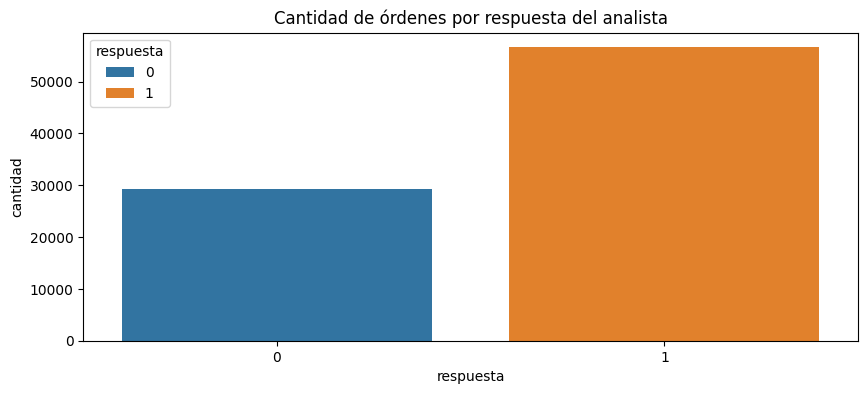

In [17]:
plt.figure(figsize=(10, 4))
sns.countplot(x='respuesta', hue='respuesta', data=df)
plt.ylabel('cantidad')
plt.title('Cantidad de órdenes por respuesta del analista');


El gráfico muestra la cantidad de órdenes clasificadas por los analistas según la variable respuesta, la cual indica si se tomó alguna acción (1) o no (0).

Existe un desbalance moderado en las respuestas:

respueta 1: 65.98%

respueta 2: 34.02%

Aunque respuesta = 1 es claramente dominante, la clase 0 todavía representa una proporción considerable del total.

In [22]:
# Agrupar por SERVICIO y obtener conteo de RESPUESTA
tabla_resumen = df.groupby('servicio')['respuesta'].value_counts().unstack(fill_value=0)

# Agregar columna con total por servicio
tabla_resumen['TOTAL'] = tabla_resumen.sum(axis=1)

# Ordenar de forma descendente
tabla_resumen_ordenada = tabla_resumen.sort_values(by='TOTAL', ascending=False)

# Mostrar resultado
tabla_resumen_ordenada


respuesta,0,1,TOTAL
servicio,,,
101-AGUA POTABLE,12916,24899,37815
701-ENERGÍA MDO REGULADO,7013,17540,24553
501-GAS NATURAL REGULADO,2403,4591,6994
249-AGUA POTABLE DE RIONEGRO ANT,4025,1908,5933
8003-AGUA POTABLE URABA,1285,2936,4221
240-AGUA POTABLE MALAMBO,397,2320,2717
7505-GAS NATURAL COMPRIMIDO (GNC),462,1392,1854
8000-AGUA POTABLE OCC.,659,963,1622
103-ALCANTARILLADO,4,58,62


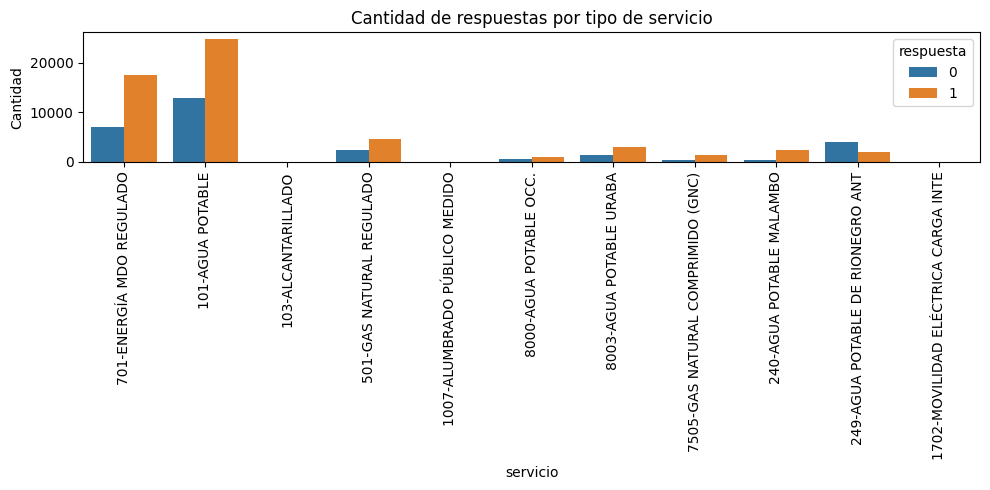

In [23]:
plt.figure(figsize=(10, 5))
sns.countplot(x='servicio', hue='respuesta', data=df)
plt.title("Cantidad de respuestas por tipo de servicio")
plt.xlabel("servicio")
plt.ylabel("Cantidad")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [25]:
# Agrupar por SERVICIO y obtener conteo de RESPUESTA
tabla_resumen = df.groupby('localidad')['respuesta'].value_counts().unstack(fill_value=0)

# Agregar columna con total por servicio
tabla_resumen['TOTAL'] = tabla_resumen.sum(axis=1)

# Ordenar de forma descendente
tabla_resumen_ordenada = tabla_resumen.sort_values(by='TOTAL', ascending=False)

# Mostrar resultado
tabla_resumen_ordenada

respuesta,0,1,TOTAL
localidad,,,
5001-MEDELLÍN,9175,19580,28755
5266-ENVIGADO,5425,10060,15485
5615-RIONEGRO,4611,3292,7903
5045-APARTADÓ,1569,5584,7153
5088-BELLO,2212,4157,6369
...,...,...,...
5125-CAICEDO,0,1,1
5660-SAN LUIS,0,1,1
5674-SAN VICENTE FERRER,0,1,1


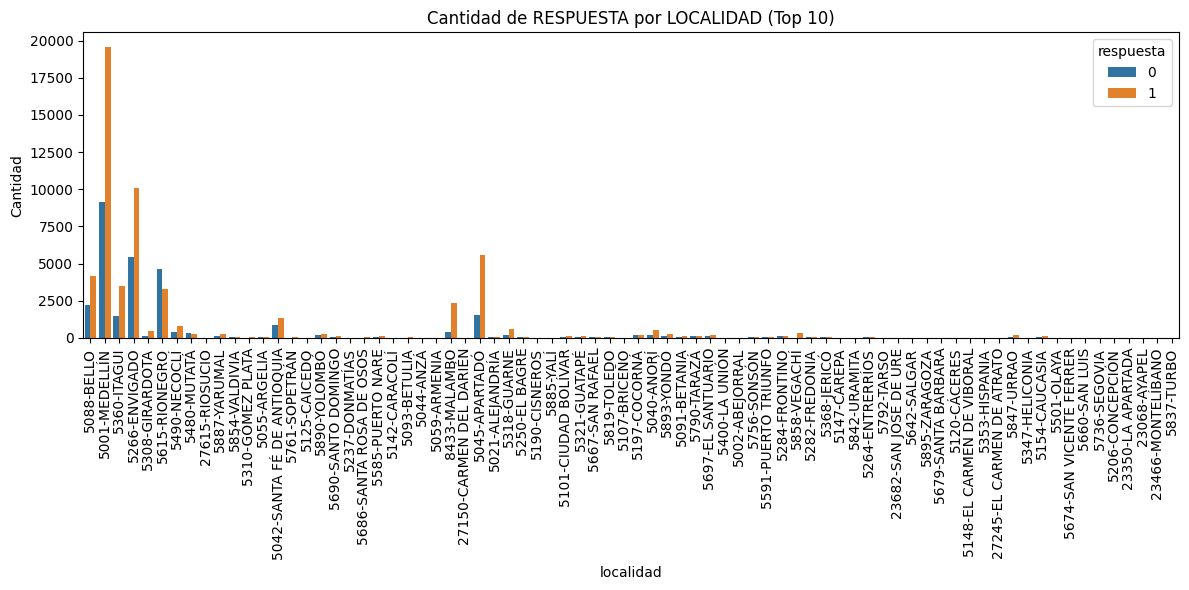

In [26]:
plt.figure(figsize=(12, 6))
#top_localidades = df['LOCALIDAD'].value_counts().nlargest(10).index
top_localidades = df['localidad'].value_counts().index
df_localidad_top = df[df['localidad'].isin(top_localidades)]
sns.countplot(x='localidad', hue='respuesta', data=df_localidad_top)
plt.title("Cantidad de RESPUESTA por LOCALIDAD (Top 10)")
plt.xlabel("localidad")
plt.ylabel("Cantidad")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [50]:
# Agrupar por SERVICIO y obtener conteo de RESPUESTA
tabla_resumen = df.groupby('CATEGORIA')['RESPUESTA'].value_counts().unstack(fill_value=0)

# Agregar columna con total por servicio
tabla_resumen['TOTAL'] = tabla_resumen.sum(axis=1)

# Ordenar de forma descendente
tabla_resumen_ordenada = tabla_resumen.sort_values(by='TOTAL', ascending=False)

# Mostrar resultado
tabla_resumen_ordenada

RESPUESTA,0,1,TOTAL
CATEGORIA,,,
1-RESIDENCIAL,25063,45940,71003
2-COMERCIAL,2403,6483,8886
3-INDUSTRIAL,1035,3443,4478
4-OFICIAL,455,578,1033
11-CONSUMOS EPMTELCO,138,43,181
5-ESPECIAL,36,73,109
7-AUTOCONSUMOS EPM,47,31,78
5-EXENTA,15,24,39
14-ENERGIA BOMBEO ACUEDUCTO,1,3,4


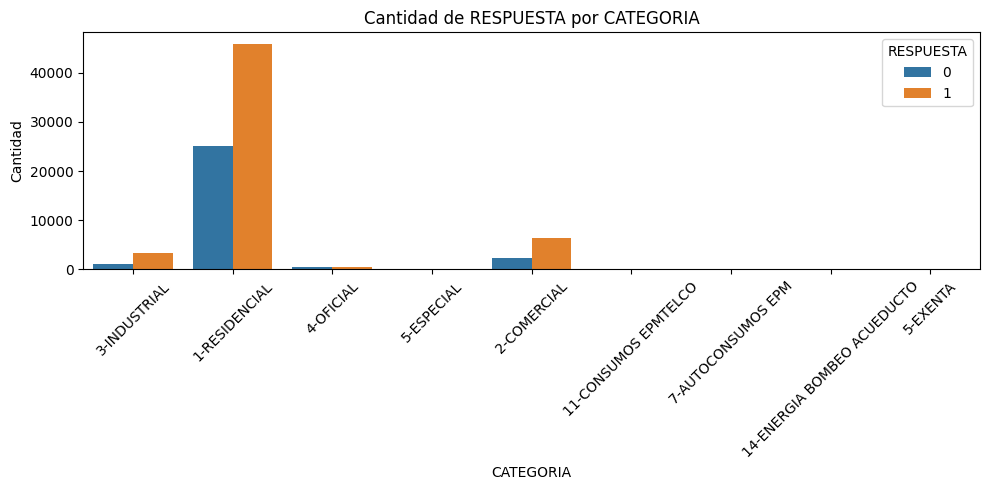

In [51]:
plt.figure(figsize=(10, 5))
sns.countplot(x='CATEGORIA', hue='RESPUESTA', data=df)
plt.title("Cantidad de RESPUESTA por CATEGORIA")
plt.xlabel("CATEGORIA")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# *3.Tratamiento de datos e imputación*

In [52]:
df_modelo = df.copy()

In [53]:
df_modelo['CODIGO_SERVICIO'] = df_modelo['SERVICIO'].str.split('-', n=1).str[0]
df_modelo.drop(columns=['SERVICIO'], inplace=True)

df_modelo['CODIGO_OBSERVACION'] = df_modelo['OBS_LECTURA'].str.split('-', n=1).str[0]
df_modelo.drop(columns=['OBS_LECTURA'], inplace=True)

df_modelo['CODIGO_CALIFICACION'] = df_modelo['CALIFICACION'].str.split('-', n=1).str[0]
df_modelo.drop(columns=['CALIFICACION'], inplace=True)

df_modelo['CODIGO_LOCALIDAD'] = df_modelo['LOCALIDAD'].str.split('-', n=1).str[0]
df_modelo.drop(columns=['LOCALIDAD'], inplace=True)

df_modelo['CODIGO_CATEGORIA'] = df_modelo['CATEGORIA'].str.split('-', n=1).str[0]
df_modelo.drop(columns=['CATEGORIA'], inplace=True)

In [54]:

# Columnas categóricas a codificar
columnas_categoricas = ['FUNCION_ANALISIS']

# Inicializar codificadores
encoders = {}
for col in columnas_categoricas:
    le = LabelEncoder()
    df_modelo[col] = le.fit_transform(df_modelo[col].astype(str))
    encoders[col] = le  # Guardamos el encoder para posibles decodificaciones posteriores

# Verificar resultado
df_modelo.head()

,RESPUESTA,CONSUMO_CRITICADO,NIVEL_TENSION,ESTRATO,FUNCION_ANALISIS,PERIODICIDAD,CODIGO_SERVICIO,CODIGO_OBSERVACION,CODIGO_CALIFICACION,CODIGO_LOCALIDAD,CODIGO_CATEGORIA
0,1,0.0,220.0,NaN,3,1,701,30,5035,5088,3
1,1,420.0,220.0,NaN,3,1,701,30,5080,5088,3
2,1,99999.0,NaN,1.0,2,1,101,34,5080,5088,1
3,1,881.0,220.0,NaN,2,1,701,35,5080,5088,3
4,1,99999.0,220.0,4.0,2,1,701,34,5080,5001,1


In [55]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85811 entries, 0 to 85810
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RESPUESTA            85811 non-null  int64  
 1   CONSUMO_CRITICADO    85811 non-null  float64
 2   NIVEL_TENSION        24593 non-null  float64
 3   ESTRATO              71003 non-null  float64
 4   FUNCION_ANALISIS     85811 non-null  int32  
 5   PERIODICIDAD         85811 non-null  int64  
 6   CODIGO_SERVICIO      85811 non-null  object 
 7   CODIGO_OBSERVACION   85811 non-null  object 
 8   CODIGO_CALIFICACION  85811 non-null  object 
 9   CODIGO_LOCALIDAD     85811 non-null  object 
 10  CODIGO_CATEGORIA     85811 non-null  object 
dtypes: float64(3), int32(1), int64(2), object(5)
memory usage: 6.9+ MB


In [56]:
df_modelo.describe()

,RESPUESTA,CONSUMO_CRITICADO,NIVEL_TENSION,ESTRATO,FUNCION_ANALISIS,PERIODICIDAD
count,85811.000000,8.581100e+04,24593.000000,71003.000000,85811.000000,85811.000000
mean,0.659799,4.264194e+07,777.438295,3.236680,4.412313,1.102073
std,0.473779,4.818349e+09,3001.450014,1.512711,2.827490,0.427672
min,0.000000,-1.600808e+06,220.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000e+00,220.000000,2.000000,2.000000,1.000000
50%,1.000000,1.250000e+01,220.000000,3.000000,3.000000,1.000000
75%,1.000000,1.550000e+02,220.000000,4.000000,6.000000,1.000000
max,1.000000,7.333327e+11,44000.000000,6.000000,13.000000,3.000000


# *4.Medidas y gráficas descriptivas multivariadas*

In [57]:
df_modelo.corr()

,RESPUESTA,CONSUMO_CRITICADO,NIVEL_TENSION,ESTRATO,FUNCION_ANALISIS,PERIODICIDAD,CODIGO_SERVICIO,CODIGO_OBSERVACION,CODIGO_CALIFICACION,CODIGO_LOCALIDAD,CODIGO_CATEGORIA
RESPUESTA,1.000000,-0.004129,0.066111,-0.100899,-0.014113,-0.027790,0.024368,0.214283,0.096435,0.012204,0.012509
CONSUMO_CRITICADO,-0.004129,1.000000,0.204490,-0.009655,-0.000442,-0.002110,-0.001293,0.002943,-0.012312,-0.002961,0.019206
NIVEL_TENSION,0.066111,0.204490,1.000000,NaN,-0.055757,-0.084617,-0.006348,0.046699,-0.004647,-0.013809,0.202807
ESTRATO,-0.100899,-0.009655,NaN,1.000000,-0.180379,-0.308941,-0.255220,0.229940,0.185263,-0.256115,NaN
FUNCION_ANALISIS,-0.014113,-0.000442,-0.055757,-0.180379,1.000000,0.270444,-0.047260,-0.258138,-0.499430,0.103445,-0.066174
PERIODICIDAD,-0.027790,-0.002110,-0.084617,-0.308941,0.270444,1.000000,-0.034712,-0.199665,-0.231723,0.108382,-0.040126
CODIGO_SERVICIO,0.024368,-0.001293,-0.006348,-0.255220,-0.047260,-0.034712,1.000000,-0.154166,0.051037,-0.069449,-0.034856
CODIGO_OBSERVACION,0.214283,0.002943,0.046699,0.229940,-0.258138,-0.199665,-0.154166,1.000000,0.376905,-0.077704,0.016641
CODIGO_CALIFICACION,0.096435,-0.012312,-0.004647,0.185263,-0.499430,-0.231723,0.051037,0.376905,1.000000,-0.132030,0.024183
CODIGO_LOCALIDAD,0.012204,-0.002961,-0.013809,-0.256115,0.103445,0.108382,-0.069449,-0.077704,-0.132030,1.000000,-0.028241


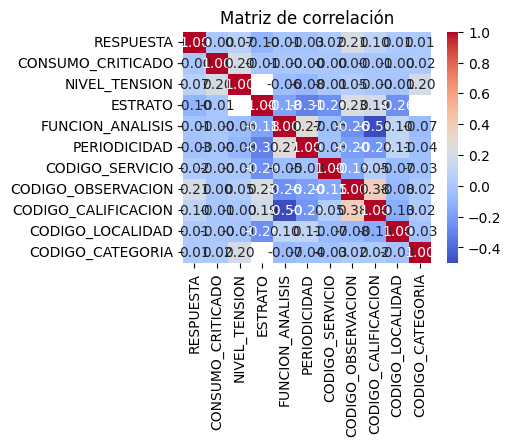

In [58]:
# Verificamos correlación entre numéricas
plt.figure(figsize=(4, 3))
sns.heatmap(df_modelo.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

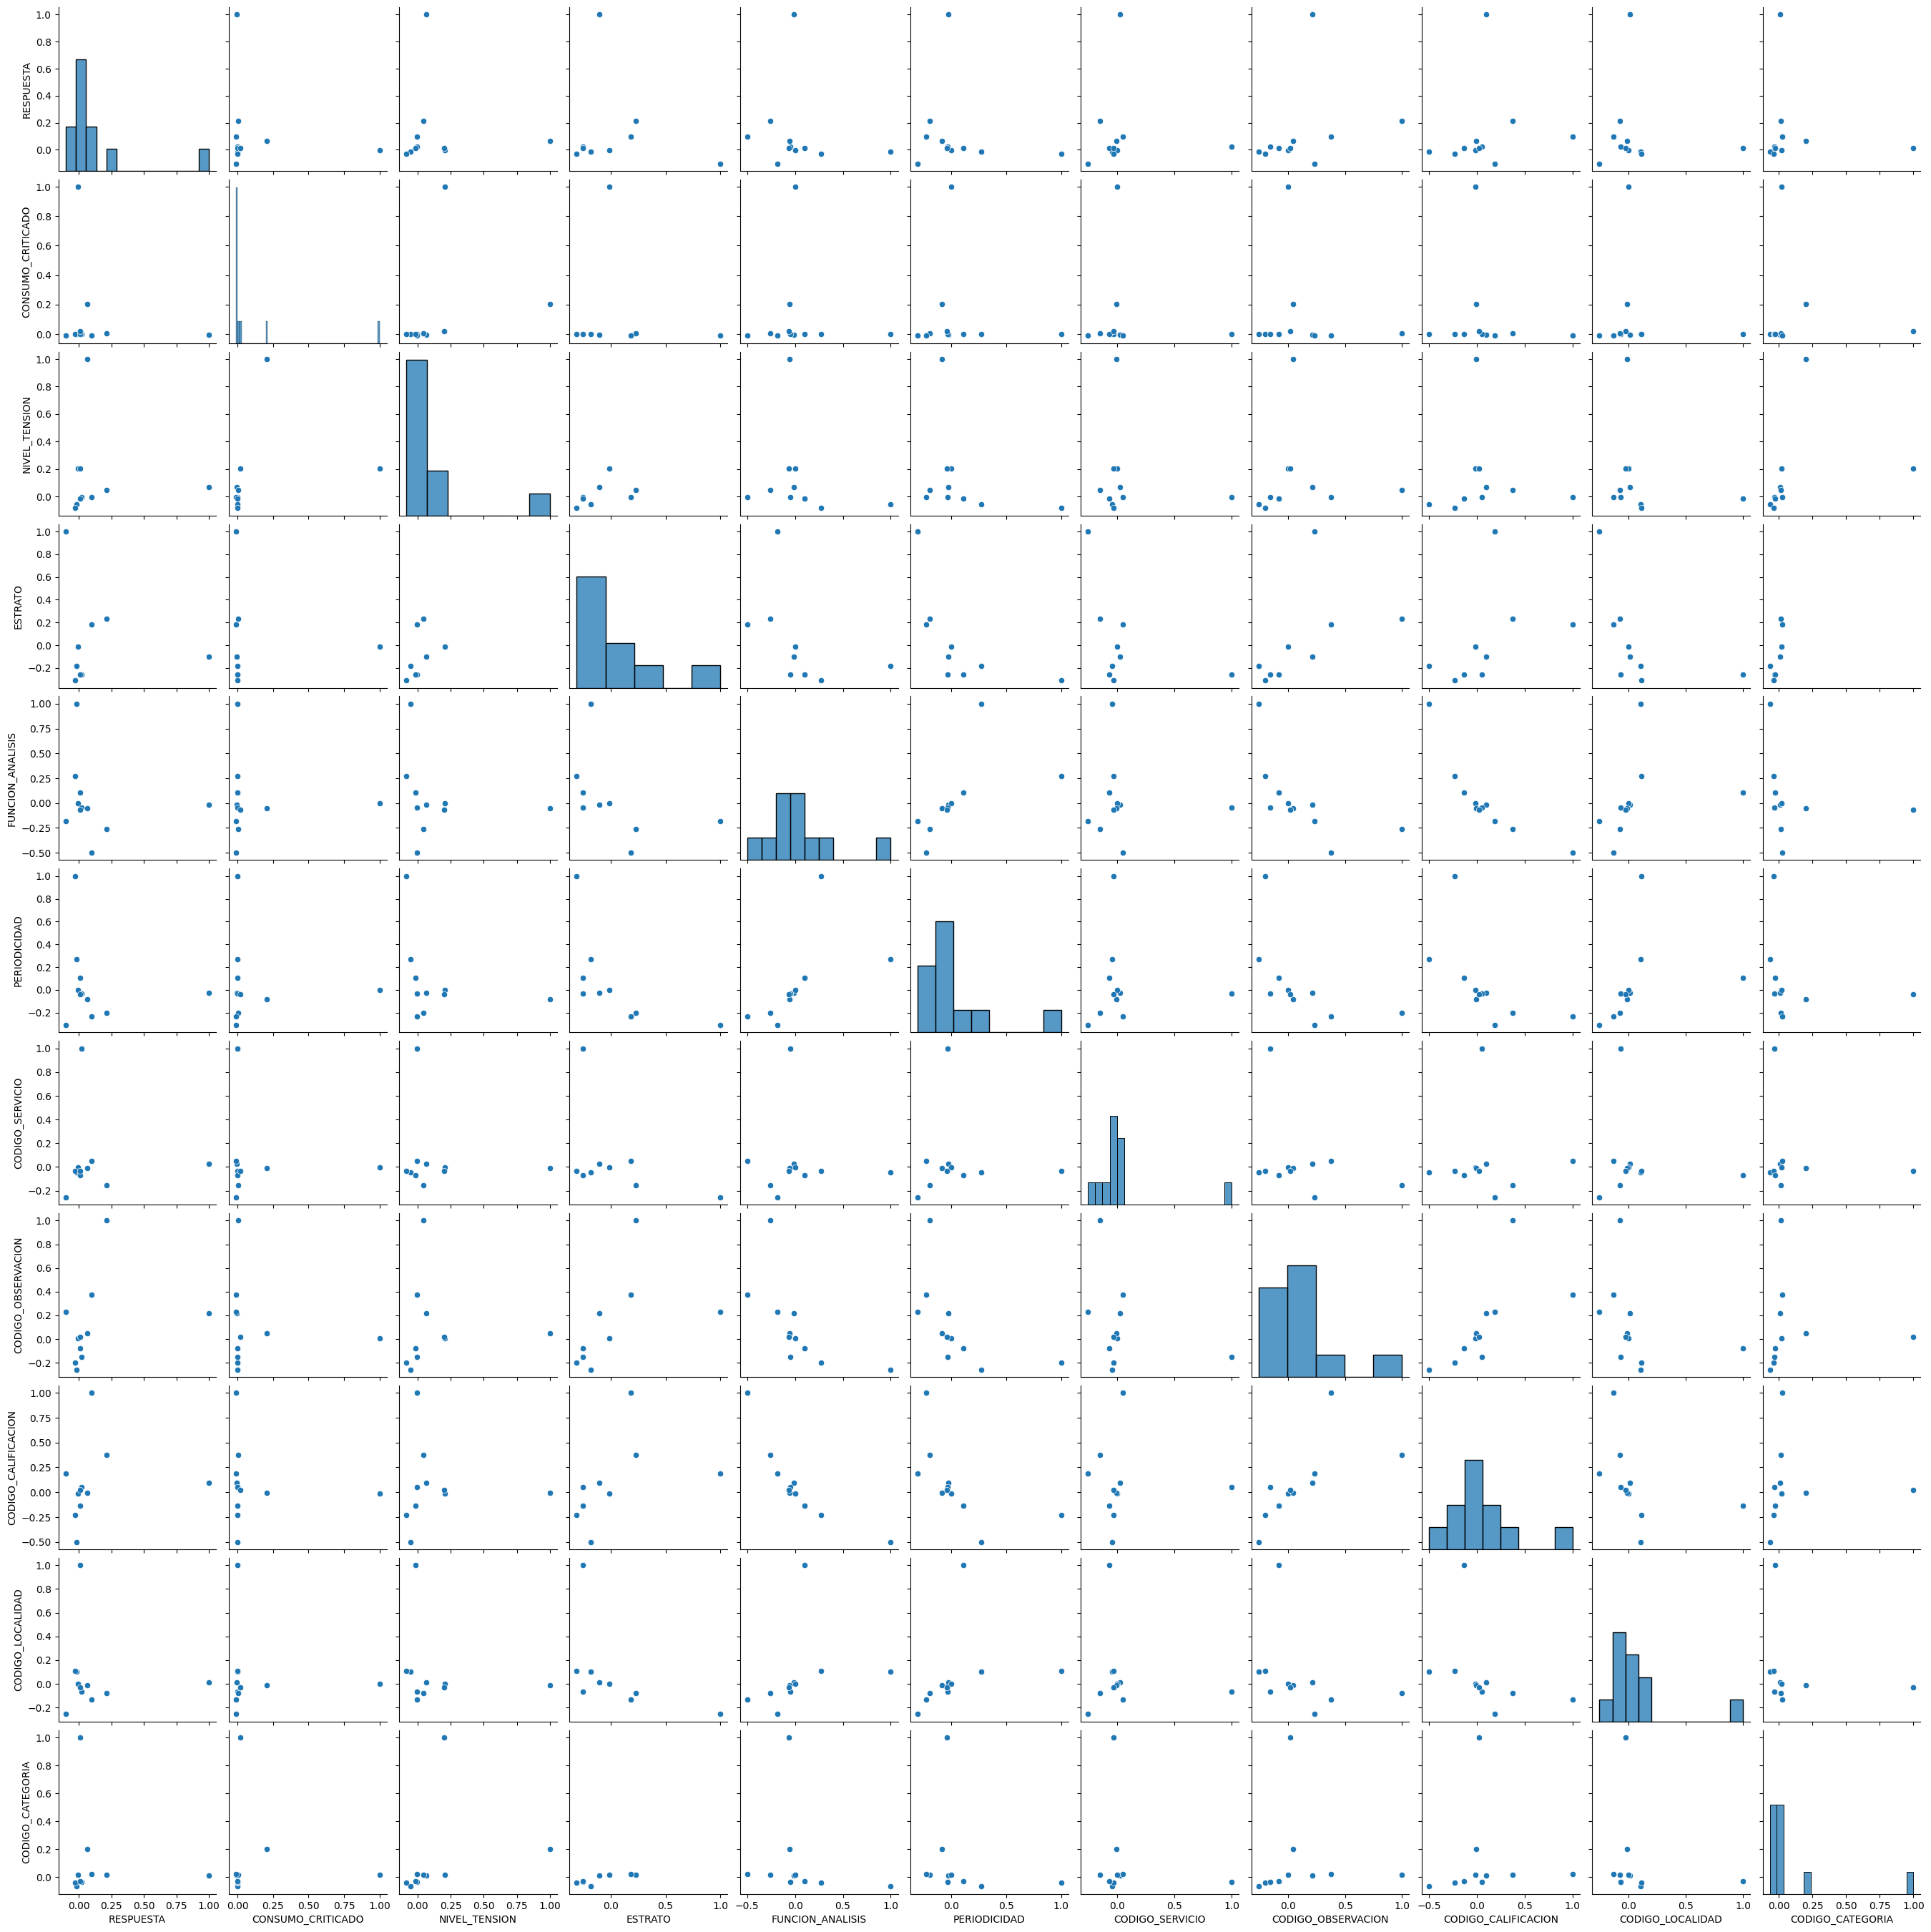

In [59]:
sns.pairplot(df_modelo.corr())

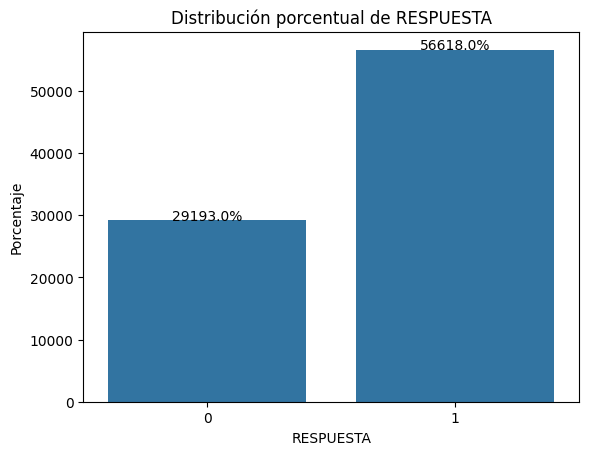

In [ ]:
# Crear el gráfico
ax = sns.countplot(x='RESPUESTA', data=df_modelo)

# Agregar etiquetas a las barras
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,   # Posición horizontal
        height + 1,                      # Posición vertical un poco encima de la barra
        f'{height:.1f}%',                # Texto con un decimal y %
        ha='center'                      # Alineación horizontal
    )

plt.title("Distribución porcentual de RESPUESTA")
plt.ylabel("Porcentaje")
plt.show()

#Data desbalanceada como en este caso usar F1 score, el accuracy es mejor para data balanceada.